In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10160976730144886356
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2238133044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 499567491450083655
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [1]:
import shutil
# Import all necessary libraries
# try:
#     %tensorflow_version 2.x
# except Exception:
#     pass
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import models
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Model, load_model
from keras.utils import plot_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras_tuner import RandomSearch



from sklearn.cluster import KMeans
import tensorflow_text as text

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from nltk.stem import WordNetLemmatizer

import bert
# from bert import bert_tokenization

import numpy as np 
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
import re
import cv2
from PIL import Image
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import skimage
import string

import albumentations as A
import seaborn as sns
import random
import os

In [11]:
import skimage

def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    
image = skimage.io.imread('https://i.ytimg.com/vi/fnNMs3O23uE/hq720.jpg?sqp=-oaymwE2CNAFEJQDSFXyq4qpAygIARUAAIhCGAFwAcABBvABAfgB_gmAAtAFigIMCAAQARhyIFIoNDAP&rs=AOn4CLCPUwmpbHBgy3AQo2wPh1ph23EZCw')
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.resize(image, (480, 360))

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


# Function

In [2]:
EMOJI_PATTERN = re.compile(
    "["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "\U000024C2-\U0001F251" 
    "]+")

def text_processing(sentences):
    kalimat = sentences
    kalimat_lower = kalimat.lower()
    kalimat_nonum = re.sub(r"\d+", "", kalimat_lower)
    kalimat_nomention = re.sub(r'(@[A-Za-z0-9_]+)', '', kalimat_nonum)
    kalimat_nohashtag = re.sub(r'(#[A-Za-z0-9_]+)','', kalimat_nomention)
    kalimat_nolink = re.sub('http://\S+|https://\S+', '', kalimat_nohashtag)
    kalimat_nopunct = kalimat_nolink.translate(str.maketrans("","",string.punctuation))
    kalimat_nopunct2 = re.sub(r'[^\w\s]','', kalimat_nopunct)
    kalimat_nospace = kalimat_nopunct2.strip()
    kalimat_noemot = re.sub(EMOJI_PATTERN, '', kalimat_nospace)
    
    return kalimat_noemot

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

def isEnglish(s):
    return s.isascii()

In [3]:
def title_adjusment_for_model(text):
    list_of_title = []
    
    step1 = text_processing(text)
    step2 = lemmatize_words(step1)
    list_of_title.append(step2)
    return step2
    

def thumbnail_adjusment_for_model(image_link):
    list_of_thumbnail = []
    
    img = cv2.imread(image_link)
    img = img[50:310, 5:475]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    img = cv2.resize(img, (235, 130))
    list_of_thumbnail.append(img)
    
    return np.array(img)

def load_images_from_df_but_LUV(df):
    images = []
    for filename in df:
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        img = img[50:310, 5:475]
        img = cv2.resize(img, (235, 130))
        if img is not None:
            images.append(img)
    return np.array(images, dtype='uint8')

def load_images_from_df_but_LUV2(df):
    images = []
    for filename in df:
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        img = img[50:310, 5:475]
        # img = cv2.resize(img, (235, 130))
        if img is not None:
            images.append(img)
    return np.array(images, dtype='uint8')

def load_images_from_df_but_RGB(df):
    images = []
    for filename in df:
        img = cv2.imread(filename)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[50:310, 5:475]
        if img is not None:
            images.append(img)
    return np.array(images)

def binary_result(prediction_array):
    binary_prediction = np.where(prediction_array > 0.5, 1, 0)
    
    return binary_prediction

def downsampling(img):
    lower_img = cv2.pyrDown(img)
    return lower_img

def get_X_y(df):
    X_txt, X_img = [], []
    y = []
    
    for i in range(len(df)):
        X_txt.append(df['Title'].iloc[i])
        X_img.append(df['Image Array'].iloc[i])
        y.append(df['Kesimpulan'].iloc[i])

    X_txt, X_img = np.array(X_txt), np.array(X_img)
    y_fix = np.array(y)

    return (X_txt, X_img), y_fix

def show_performance_curve(training_result, metric, metric_label):
    
	train_perf = training_result.history[str(metric)]
	validation_perf = training_result.history['val_'+str(metric)]
    
    
	plt.plot(train_perf, label=metric_label)
	plt.plot(validation_perf, label = 'val_'+str(metric))
	plt.xlabel('Epoch')
	plt.ylabel(metric_label)
	plt.legend(loc='lower right')

# Data Preparation

In [10]:
df_after_labelling_datasheet = pd.read_excel("Phase 3_done.xlsx", sheet_name='Audyy')[['Title', 'Path']].dropna()
# print(df_after_labelling_datasheet.shape)

df_after_labelling_adminsheet = pd.read_excel("Phase 3_done.xlsx", sheet_name='Admin')['Kesimpulan'].dropna().astype(int)
df_after_labelling_adminsheet.drop(df_after_labelling_adminsheet.tail(1).index, inplace=True)
# print(df_after_labelling_adminsheet.shape)

df_after_labelling = pd.concat([df_after_labelling_datasheet, df_after_labelling_adminsheet], axis=1)
df_after_labelling.head()


,Title,Path,Kesimpulan
0,Baby Anna and Elsa Learn About the Enchanted F...,not_elsagate_2/not_elsagate_134.png,0
1,Peppa and George wash the car (clip) | Peppa P...,not_elsagate_2/not_elsagate_261.png,0
2,Toy Vehicles Collection for Kids,not_elsagate_2/not_elsagate_25.png,0
3,Teen Titans Go! | Tragic Endings For The Titan...,not_elsagate_2/not_elsagate_448.png,0
4,"Help Wednesday Addams, Frozen Elsa, Ronaldo CR...",elsagate_2/elsagate_192.png,1


In [11]:
df_after_labelling['Title'] = df_after_labelling['Title'].apply(title_adjusment_for_model)
df_after_labelling.head()

,Title,Path,Kesimpulan
0,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0
1,peppa and george wash the car clip peppa pig o...,not_elsagate_2/not_elsagate_261.png,0
2,toy vehicle collection for kid,not_elsagate_2/not_elsagate_25.png,0
3,teen titan go tragic ending for the titan,not_elsagate_2/not_elsagate_448.png,0
4,help wednesday addams frozen elsa ronaldo cr a...,elsagate_2/elsagate_192.png,1


In [12]:
non_english_words = []

for i in df_after_labelling["Title"]:
    if isEnglish(i) == False:
        non_english_words.append(i)

condition = df_after_labelling['Title'].isin(non_english_words)
df_after_labelling = df_after_labelling[~condition].reset_index(drop=True)
df_after_labelling.shape

(515, 3)

## Augmentation

In [12]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    
image = cv2.imread('not_elsagate_2/not_elsagate_3.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (480, 360))

# random.seed(5)

In [13]:
def augment_image(image):
    transform = A.Compose([
        A.Rotate(limit=(-45, 45), p=0.2),
        A.Morphological(p=0.2),
        A.Flip(),
        A.RandomBrightnessContrast(),
        A.Perspective(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.OneOf([
            A.OpticalDistortion(distort_limit=(-0.3, 0.3), p=0.1),
            A.GridDistortion(distort_limit=(-0.1, 0.1), p=0.1),
        ], p=0.2),
        A.HueSaturationValue(p=0.4),
    ])
    augmented_image = transform(image=image)  # Convert tf.Tensor to numpy
    return augmented_image['image']

In [14]:
df_aug = df_after_labelling.copy()

rgb_im = load_images_from_df_but_RGB(df_after_labelling['Path'])
rgb_im = list(rgb_im)

df_aug['Image Array'] = rgb_im
df_aug.head()

,Title,Path,Kesimpulan,Image Array
0,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[63, 4, 24], [63, 4, 24], [63, 4, 24], [63, ..."
1,peppa and george wash the car clip peppa pig o...,not_elsagate_2/not_elsagate_261.png,0,"[[[249, 192, 147], [249, 192, 147], [249, 192,..."
2,toy vehicle collection for kid,not_elsagate_2/not_elsagate_25.png,0,"[[[247, 155, 76], [239, 157, 76], [241, 156, 7..."
3,teen titan go tragic ending for the titan,not_elsagate_2/not_elsagate_448.png,0,"[[[254, 244, 97], [254, 244, 97], [254, 244, 9..."
4,help wednesday addams frozen elsa ronaldo cr a...,elsagate_2/elsagate_192.png,1,"[[[91, 159, 248], [93, 159, 242], [97, 162, 24..."


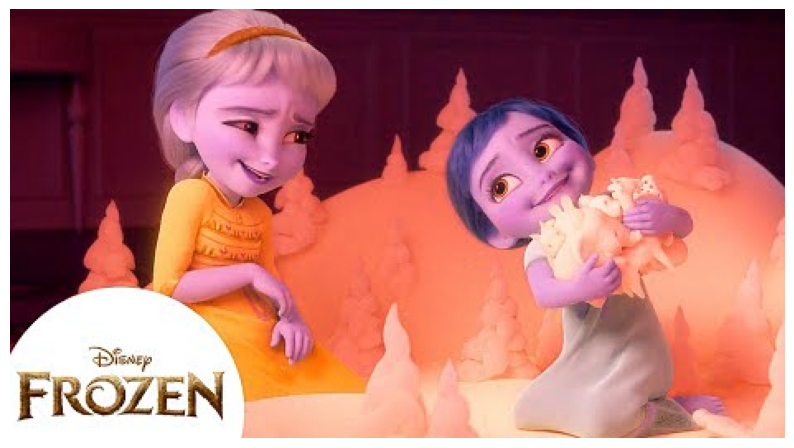

In [ ]:
visualize(df_aug['Image'][0])

In [15]:
real_df_aug = pd.DataFrame(np.repeat(df_aug.values, 10, axis=0))
real_df_aug.columns = df_aug.columns
real_df_aug.head(20)

,Title,Path,Kesimpulan,Image Array
0,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[63, 4, 24], [63, 4, 24], [63, 4, 24], [63, ..."
1,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[63, 4, 24], [63, 4, 24], [63, 4, 24], [63, ..."
2,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[63, 4, 24], [63, 4, 24], [63, 4, 24], [63, ..."
3,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[63, 4, 24], [63, 4, 24], [63, 4, 24], [63, ..."
4,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[63, 4, 24], [63, 4, 24], [63, 4, 24], [63, ..."
5,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[63, 4, 24], [63, 4, 24], [63, 4, 24], [63, ..."
6,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[63, 4, 24], [63, 4, 24], [63, 4, 24], [63, ..."
7,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[63, 4, 24], [63, 4, 24], [63, 4, 24], [63, ..."
8,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[63, 4, 24], [63, 4, 24], [63, 4, 24], [63, ..."
9,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[63, 4, 24], [63, 4, 24], [63, 4, 24], [63, ..."


In [16]:
n = 9
ori_plus_augment = []
random.seed(21)

for i in range(len(df_aug)):
    image_to_augment = df_aug['Image Array'][i]
    cv2.imwrite(f'augmented/{i}.png', image_to_augment)
    ori_plus_augment.append(image_to_augment)
    
    for j in range(n):
        start_augmentation = augment_image(image_to_augment)
        cv2.imwrite(f'augmented/{i}_{j}.png', start_augmentation)
        ori_plus_augment.append(start_augmentation)

print(len(ori_plus_augment))
print(len(os.listdir('augmented')))

5150
5150


In [17]:
real_df_aug['Image Array'] = ori_plus_augment
real_df_aug['Image Array'] = real_df_aug['Image Array'].apply(downsampling)
real_df_aug.head()

,Title,Path,Kesimpulan,Image Array
0,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[61, 2, 22], [61, 2, 22], [61, 2, 22], [61, ..."
1,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[255, 74, 67], [255, 72, 65], [252, 68, 61],..."
2,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[51, 5, 48], [50, 5, 46], [49, 4, 44], [48, ..."
3,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[74, 4, 21], [73, 4, 21], [72, 4, 21], [71, ..."
4,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[46, 3, 10], [47, 3, 10], [47, 2, 9], [47, 1..."


In [38]:
# real_df_aug.to_csv('augmented_dataset.csv', index=False)
real_df_aug.to_pickle('augmented_dataset.csv')

In [5]:
real_df_aug = pd.read_pickle('augmented_dataset.csv')
real_df_aug.head()

,Title,Path,Kesimpulan,Image Array
0,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[61, 2, 22], [61, 2, 22], [61, 2, 22], [61, ..."
1,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[255, 74, 67], [255, 72, 65], [252, 68, 61],..."
2,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[51, 5, 48], [50, 5, 46], [49, 4, 44], [48, ..."
3,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[74, 4, 21], [73, 4, 21], [72, 4, 21], [71, ..."
4,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[46, 3, 10], [47, 3, 10], [47, 2, 9], [47, 1..."


In [6]:
tr, va, te = np.split(real_df_aug.sample(frac=1, random_state=42), [int(.8*len(real_df_aug)), int(.9*len(real_df_aug))])
# tr, va, te = np.split(real_df_aug.sample(frac=1, random_state=42), [int(.6*len(real_df_aug)), int(.8*len(real_df_aug))])

(X_train_txt_aug, X_train_img_aug), y_train_aug = get_X_y(tr)
(X_val_txt_aug, X_val_img_aug), y_val_aug = get_X_y(va)
(X_test_txt_aug, X_test_img_aug), y_test_aug = get_X_y(te)

c:\Users\farras\anaconda3\envs\skripsi\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
X_val_txt_aug.shape

(515,)

## Standart Preparation

In [18]:
image_array = load_images_from_df_but_LUV2(df_after_labelling['Path'])
image_array = list(image_array)

df_after_labelling['Image Array'] = image_array


df_after_labelling['Image Array'] = df_after_labelling['Image Array'].apply(downsampling)
df_after_labelling.head(5)

,Title,Path,Kesimpulan,Image Array
0,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[24, 114, 136], [24, 114, 136], [24, 114, 13..."
1,peppa and george wash the car clip peppa pig o...,not_elsagate_2/not_elsagate_261.png,0,"[[[208, 126, 173], [208, 126, 173], [208, 126,..."
2,toy vehicle collection for kid,not_elsagate_2/not_elsagate_25.png,0,"[[[184, 146, 191], [184, 147, 191], [183, 151,..."
3,teen titan go tragic ending for the titan,not_elsagate_2/not_elsagate_448.png,0,"[[[242, 106, 221], [241, 106, 221], [241, 106,..."
4,help wednesday addams frozen elsa ronaldo cr a...,elsagate_2/elsagate_192.png,1,"[[[165, 76, 59], [166, 76, 61], [166, 76, 61],..."


In [19]:
bener = []
for i in df_after_labelling['Image Array']:
    x = i.astype(np.float32)
    bener.append(x)

df_after_labelling['Image Array'] = bener
type(df_after_labelling['Image Array'][0])

numpy.ndarray

In [20]:
inputs = np.array(df_after_labelling[['Title', 'Image Array']])
targets = np.array(df_after_labelling['Kesimpulan'])
inputs.shape
# targets.shape

(515, 2)

In [16]:
(X_txt, X_img), y = get_X_y(real_df_aug)
# Get theing data
(X_txt.shape, X_img.shape), y.shape

(((5150,), (5150, 130, 235, 3)), (5150,))

In [136]:
train_df, val_df, test_df = df_after_labelling[:416], df_after_labelling[416:468], df_after_labelling[468:]
print(train_df.shape)

(X_train_txt, X_train_img), y_train = get_X_y(train_df)
(X_val_txt, X_val_img), y_val = get_X_y(val_df)

(416, 4)


## Model Requirement

In [7]:
bert_preprocess2 = hub.KerasLayer("C:\\SAINS DATA\\PERSKRIPSIAN DUNIAWI\\bert1")
bert_encoder2 = hub.KerasLayer("C:\\SAINS DATA\\PERSKRIPSIAN DUNIAWI\\bert2")

In [8]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]

# Standart Modelling

In [13]:
# TEXT INPUT
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_text')
preprocessed_text = bert_preprocess2(text_input)
outputs = bert_encoder2(preprocessed_text)

# Neural network layers
string_layer = tf.keras.layers.Reshape((1,768))(outputs['pooled_output'])
string_layer = tf.keras.layers.SpatialDropout1D(0.4)(string_layer)
string_layer = tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)(string_layer)
string_layer = layers.Dropout(0.1)(string_layer)
string_layer = tf.keras.layers.LSTM(32, activation='relu', return_sequences=False)(string_layer)
string_layer = tf.keras.layers.Dense(40, activation='relu')(string_layer)
string_layer = layers.Dropout(0.1)(string_layer)

#IMAGE INPUT 
visible = Input(shape=(130, 235, 3))
image_layer = Conv2D(32, kernel_size=3, activation='relu')(visible)
# conv1 = Conv2D(16, kernel_size=3, activation='relu')(conv1)
# image_layer = layers.BatchNormalization()(image_layer)
image_layer = MaxPooling2D(pool_size=(3, 3))(image_layer)
image_layer = Conv2D(32, kernel_size=3, activation='relu')(image_layer)
image_layer = layers.BatchNormalization()(image_layer)
image_layer = MaxPooling2D(pool_size=(3, 3))(image_layer)
image_layer = Conv2D(64, kernel_size=4, activation='relu')(image_layer)
image_layer = MaxPooling2D(pool_size=(2, 2))(image_layer)
image_layer = Conv2D(8, kernel_size=4, activation='relu')(image_layer)
image_layer = layers.BatchNormalization()(image_layer)
image_layer = MaxPooling2D(pool_size=(2, 2))(image_layer)
image_layer = Flatten()(image_layer)
image_layer = Dense(20, activation = 'relu')(image_layer)
image_layer = layers.Dropout(0.3)(image_layer)

# merge input models
merge = concatenate([string_layer, image_layer])

# interpretation model
merge = layers.ActivityRegularization(l2=0.001)(merge)
merge = layers.Dense(128, activation = 'relu', name='Dense_128')(merge)
# merge = layers.Dropout(0.1)(merge)
merge = layers.Dense(224, activation = 'relu', name='Dense_16')(merge)
merge = layers.Dense(32, activation = 'relu', name='Dense_36')(merge)
merge = layers.Dropout(0.1)(merge)
output = Dense(1, activation='sigmoid')(merge)

final_model = Model(inputs=[text_input, visible], outputs=output)
final_model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 130, 235, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 233, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 42, 77, 32)  0           ['conv2d_4[0][0]']               
                                                                                            

In [14]:
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=Metrics)

In [11]:
es = EarlyStopping(monitor='val_accuracy', 
                                mode='max', # don't minimize the accuracy!
                                patience=6)
filepath="model.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [15]:
i_make_a_history = final_model.fit(x=[X_train_txt_aug, X_train_img_aug], y=y_train_aug, 
                                        validation_data=([X_val_txt_aug, X_val_img_aug], y_val_aug), 
                                        epochs=50, batch_size = 20,
                                        callbacks = [es, checkpoint])

Epoch 1/50
206/206 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.6552 - precision: 0.6497 - recall: 0.5036
Epoch 1: val_accuracy did not improve from 0.83689
206/206 [==============================] - 87s 396ms/step - loss: 0.6656 - accuracy: 0.6552 - precision: 0.6497 - recall: 0.5036 - val_loss: 0.6930 - val_accuracy: 0.5942 - val_precision: 0.6944 - val_recall: 0.2110
Epoch 2/50
206/206 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.6583 - precision: 0.6499 - recall: 0.5125
Epoch 2: val_accuracy did not improve from 0.83689
206/206 [==============================] - 79s 385ms/step - loss: 0.6307 - accuracy: 0.6583 - precision: 0.6499 - recall: 0.5125 - val_loss: 0.6685 - val_accuracy: 0.6233 - val_precision: 0.5870 - val_recall: 0.6118
Epoch 3/50
206/206 [==============================] - ETA: 0s - loss: 0.5976 - accuracy: 0.6910 - precision: 0.6761 - recall: 0.5944
Epoch 3: val_accuracy did not improve from 0.83689
206/206 [=======

In [16]:
#Evaluate finished model
final_model.evaluate([X_val_txt_aug, X_val_img_aug], y_val_aug)

17/17 [==============================] - 11s 601ms/step - loss: 0.6839 - accuracy: 0.8078 - precision: 0.7851 - recall: 0.8017


[0.6839282512664795,
 0.8077669739723206,
 0.7851239442825317,
 0.8016877770423889]

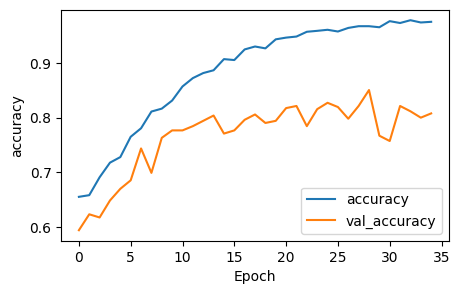

In [19]:
plt.figure(figsize=(5,3))
show_performance_curve(i_make_a_history, 'accuracy', 'accuracy')

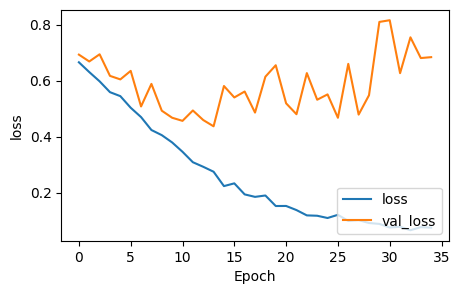

In [20]:
plt.figure(figsize=(5,3))
show_performance_curve(i_make_a_history, 'loss', 'loss')

In [7]:
saved_model = load_model('Models/8505_on_val.hdf5', custom_objects={'KerasLayer':hub.KerasLayer})
# saved_model.summary()
score_on_train = saved_model.evaluate([X_train_txt_aug, X_train_img_aug], y_train_aug)
score_on_val = saved_model.evaluate([X_val_txt_aug, X_val_img_aug], y_val_aug)
score_on_test = saved_model.evaluate([X_test_txt_aug, X_test_img_aug], y_test_aug)

17/17 [==============================] - 10s 610ms/step - loss: 0.6691 - accuracy: 0.8155 - precision: 0.8384 - recall: 0.7249


In [10]:
def f1(precision, recall):
    nilai_f1 = (2 * precision * recall)/(precision+recall)
    return nilai_f1

f1(score_on_val[2], score_on_val[3])

0.8344086033198876

In [9]:
predicted = saved_model.predict([X_val_txt_aug, X_val_img_aug])
predicted = binary_result(predicted)
cm = confusion_matrix(y_val_aug, predicted)


17/17 [==============================] - 10s 620ms/step


<Axes: >

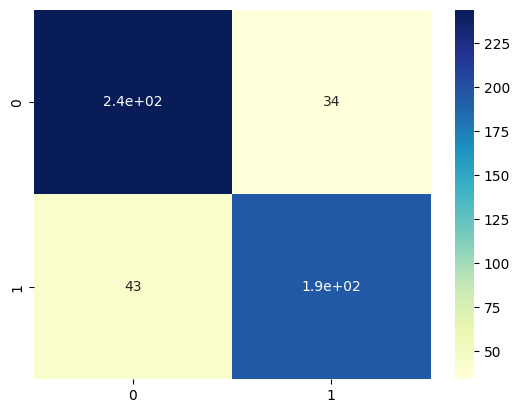

In [12]:
axis_labels = list(np.sort(real_df_aug['Kesimpulan'].unique()))
sns.heatmap(cm, annot=True, xticklabels=axis_labels, yticklabels=axis_labels,  cmap="YlGnBu")

In [15]:
saved_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 130, 235, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 233, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 42, 77, 32)  0           ['conv2d_4[0][0]']               
                                                                                            

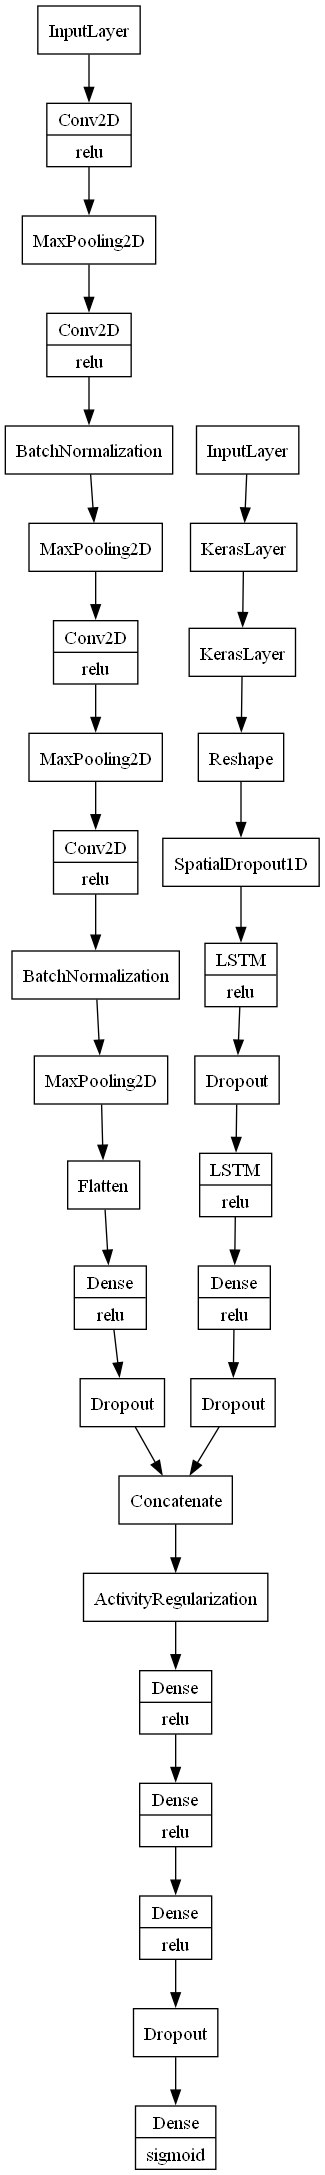

In [14]:
plot_model(saved_model, to_file='model_plot.png', show_layer_names=False, show_layer_activations=True, rankdir='TB')

# Hyperparameter Tuning

In [54]:
def build_model(hp):
    # TEXT INPUT
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_text')
    preprocessed_text = bert_preprocess2(text_input)
    outputs = bert_encoder2(preprocessed_text)

    # Neural network layers
    string_layer = tf.keras.layers.Reshape((1,768))(outputs['pooled_output'])
    string_layer = tf.keras.layers.SpatialDropout1D(0.4)(string_layer)
    string_layer = tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)(string_layer)
    string_layer = layers.Dropout(0.1)(string_layer)
    string_layer = tf.keras.layers.LSTM(64, activation='relu', return_sequences=False)(string_layer)
    
    # string_layer = tf.keras.layers.LSTM(
    #     hp.Int('lstm_1_units', min_value=32, max_value=256, step=32),
    #     activation='relu',
    #     return_sequences=True
    # )(string_layer)
    
    # string_layer = tf.keras.layers.LSTM(
    #     hp.Int('lstm_2_units', min_value=16, max_value=128, step=16),
    #     activation='relu',
    #     return_sequences=False
    # )(string_layer)
    string_layer = Dense(
        hp.Int('dense_text_units', min_value=8, max_value=96, step=16),
        activation='relu'
    )(string_layer)
    string_layer = layers.Dropout(0.1)(string_layer)

    # IMAGE INPUT 
    visible = Input(shape=(130, 235, 3))
    image_layer = Conv2D(
        hp.Int('conv_1_filters', min_value=16, max_value=64, step=16),
        kernel_size=3,
        activation='relu'
    )(visible)
    image_layer = MaxPooling2D(pool_size=(3, 3))(image_layer)
    image_layer = Conv2D(
        hp.Int('conv_2_filters', min_value=16, max_value=64, step=16),
        kernel_size=3,
        activation='relu'
    )(image_layer)
    image_layer = layers.BatchNormalization()(image_layer)
    image_layer = MaxPooling2D(pool_size=(3, 3))(image_layer)
    
    # image_layer = Conv2D(
    #     hp.Int('conv_3_filters', min_value=32, max_value=128, step=32),
    #     kernel_size=4,
    #     activation='relu'
    # )(image_layer)
    
    image_layer = Conv2D(32, kernel_size=4, activation='relu')(image_layer)
    image_layer = MaxPooling2D(pool_size=(2, 2))(image_layer)
    image_layer = Flatten()(image_layer)
    
    # image_layer = Dense(
    #     hp.Int('dense_image_units', min_value=10, max_value=40, step=10),
    #     activation='relu'
    # )(image_layer)
    
    image_layer = Dense(20, activation = 'relu')(image_layer)
    image_layer = layers.Dropout(0.3)(image_layer)

    # merge input models
    merge = concatenate([string_layer, image_layer])

    # interpretation model
    num_dense_layers = hp.Int('num_dense_layers', 1, 4)
    for i in range(num_dense_layers):
        merge = layers.Dense(
            units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
            activation='relu'
        )(merge)
        merge = layers.Dropout(hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.3, step=0.1))(merge)
        
    # merge = layers.Dense(
    #     hp.Int('dense_merge_units', min_value=8, max_value=256, step=32),
    #     activation='relu'
    # )(merge)
    # merge = layers.Dropout(0.3)(merge)
    
    output = Dense(1, activation='sigmoid')(merge)

    model = Model(inputs=[text_input, visible], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='Hyperparameter Tuning Result',
    project_name='hparam_tuning3'
)

# Now you can start the search for the best hyperparameter configuration
tuner.search(x = [X_train_txt_aug, X_train_img_aug], y = y_train_aug, 
                validation_data=([X_val_txt_aug, X_val_img_aug], y_val_aug), epochs=15)


Trial 5 Complete [01h 14m 47s]
val_accuracy: 0.8233009775479635

Best val_accuracy So Far: 0.8233009775479635
Total elapsed time: 08h 47m 04s


In [55]:
tuner.results_summary()

Results summary
Results in Hyperparameter Tuning Result\hparam_tuning3
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
dense_text_units: 40
conv_1_filters: 48
conv_2_filters: 48
num_dense_layers: 1
units_0: 256
dropout_0: 0.2
units_1: 64
dropout_1: 0.2
units_2: 224
dropout_2: 0.2
Score: 0.8233009775479635

Trial 0 summary
Hyperparameters:
dense_text_units: 24
conv_1_filters: 48
conv_2_filters: 48
num_dense_layers: 2
units_0: 160
dropout_0: 0.1
units_1: 32
dropout_1: 0.1
Score: 0.8187702496846517

Trial 3 summary
Hyperparameters:
dense_text_units: 40
conv_1_filters: 16
conv_2_filters: 32
num_dense_layers: 1
units_0: 96
dropout_0: 0.2
units_1: 128
dropout_1: 0.1
units_2: 32
dropout_2: 0.2
Score: 0.8077669938405355

Trial 2 summary
Hyperparameters:
dense_text_units: 72
conv_1_filters: 64
conv_2_filters: 64
num_dense_layers: 3
units_0: 128
dropout_0: 0.2
units_1: 256
dropout_1: 0.2
units_2: 32
dropout_2: 0.1
Score: 0.8038835128148397

In [56]:
# After search you can retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 130, 235, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_text (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 128, 233, 48  1344        ['input_1[0][0]']                
                                )                                                                 
                                                                                              

# Modelling Based on Hyperparameter Tuning Result

In [19]:
# TEXT INPUT
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_text')
preprocessed_text = bert_preprocess2(text_input)
outputs = bert_encoder2(preprocessed_text)

# Neural network layers
string_layer = tf.keras.layers.Reshape((1,768))(outputs['pooled_output'])
string_layer = tf.keras.layers.SpatialDropout1D(0.4)(string_layer)
string_layer = tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)(string_layer)
string_layer = layers.Dropout(0.1)(string_layer)
string_layer = tf.keras.layers.LSTM(64, activation='relu', return_sequences=False)(string_layer)
string_layer = tf.keras.layers.Dense(40, activation='relu')(string_layer)

#IMAGE INPUT
visible = Input(shape=(130, 235, 3))
image_layer = Conv2D(48, kernel_size=3, activation='relu')(visible)
image_layer = MaxPooling2D(pool_size=(3, 3))(image_layer)

image_layer = Conv2D(48, kernel_size=3, activation='relu')(image_layer)
image_layer = layers.BatchNormalization()(image_layer)
image_layer = MaxPooling2D(pool_size=(3, 3))(image_layer)

image_layer = Conv2D(32, kernel_size=4, activation='relu')(image_layer)
image_layer = MaxPooling2D(pool_size=(2, 2))(image_layer)
image_layer = Flatten()(image_layer)

image_layer = Flatten()(image_layer)
image_layer = Dense(20, activation = 'relu')(image_layer)
image_layer = layers.Dropout(0.3)(image_layer)

# merge input models
merge = concatenate([string_layer, image_layer])

# interpretation model
merge = layers.Dense(256, activation = 'relu', name='Dense_128')(merge)
merge = layers.Dropout(0.2)(merge)
merge = layers.Dense(64, activation = 'relu', name='Dense_36')(merge)
merge = layers.Dense(224, activation = 'relu', name='Dense_224')(merge)
merge = layers.Dropout(0.2)(merge)
output = Dense(1, activation='sigmoid')(merge)

HT_model = Model(inputs=[text_input, visible], outputs=output)
HT_model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 130, 235, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 233, 48  1344        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 42, 77, 48)  0           ['conv2d_3[0][0]']               
                                                                                            

In [20]:
HT_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=Metrics)

In [21]:
es = EarlyStopping(monitor='val_accuracy', 
                                mode='max', # don't minimize the accuracy!
                                patience=6)
filepath="model.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [22]:
history_with_HT = HT_model.fit(x=[X_train_txt_aug, X_train_img_aug], y=y_train_aug, 
                                        validation_data=([X_val_txt_aug, X_val_img_aug], y_val_aug), 
                                        epochs=50, batch_size = 20,
                                        callbacks = [es, checkpoint])

Epoch 1/50
206/206 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.5750 - precision: 0.5344 - recall: 0.3921
Epoch 1: val_accuracy improved from -inf to 0.62136, saving model to model.best.hdf5
206/206 [==============================] - 127s 544ms/step - loss: 0.6771 - accuracy: 0.5750 - precision: 0.5344 - recall: 0.3921 - val_loss: 0.6725 - val_accuracy: 0.6214 - val_precision: 0.5691 - val_recall: 0.7300
Epoch 2/50
206/206 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.6192 - precision: 0.5869 - recall: 0.5038
Epoch 2: val_accuracy did not improve from 0.62136
206/206 [==============================] - 110s 532ms/step - loss: 0.6505 - accuracy: 0.6192 - precision: 0.5869 - recall: 0.5038 - val_loss: 0.7007 - val_accuracy: 0.5573 - val_precision: 0.6452 - val_recall: 0.0844
Epoch 3/50
206/206 [==============================] - ETA: 0s - loss: 0.6252 - accuracy: 0.6539 - precision: 0.6169 - recall: 0.5982
Epoch 3: val_accuracy improved 

# Cross Validation

In [35]:
def my_model():
    # TEXT INPUT
    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_text')
    preprocessed_text = bert_preprocess2(text_input)
    outputs = bert_encoder2(preprocessed_text)

    # Neural network layers
    string_layer = tf.keras.layers.Reshape((1,768))(outputs['pooled_output'])
    string_layer = tf.keras.layers.SpatialDropout1D(0.4)(string_layer)
    string_layer = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(string_layer)
    string_layer = layers.Dropout(0.1)(string_layer)
    string_layer = tf.keras.layers.LSTM(32, activation='relu', return_sequences=False)(string_layer)
    string_layer = tf.keras.layers.Dense(10, activation='relu')(string_layer)
    # string_layer = tf.keras.layers.Dense(5, activation='relu')(string_layer)
    string_layer = layers.Dropout(0.1)(string_layer)

    #IMAGE INPUT 
    visible = Input(shape=(130, 235, 3))
    image_layer = Conv2D(8, kernel_size=3, activation='relu')(visible)
    # conv1 = Conv2D(16, kernel_size=3, activation='relu')(conv1)
    # image_layer = layers.BatchNormalization()(image_layer)
    image_layer = MaxPooling2D(pool_size=(3, 3))(image_layer)
    image_layer = Conv2D(32, kernel_size=3, activation='relu')(image_layer)
    image_layer = layers.BatchNormalization()(image_layer)
    image_layer = MaxPooling2D(pool_size=(3, 3))(image_layer)
    image_layer = Conv2D(32, kernel_size=4, activation='relu')(image_layer)
    image_layer = MaxPooling2D(pool_size=(2, 2))(image_layer)
    image_layer = Conv2D(8, kernel_size=4, activation='relu')(image_layer)
    image_layer = layers.BatchNormalization()(image_layer)
    image_layer = MaxPooling2D(pool_size=(2, 2))(image_layer)
    # drop1 = layers.SpatialDropout2D(0.5)(pool4)
    image_layer = Flatten()(image_layer)
    image_layer = Dense(4, activation = 'relu')(image_layer)
    image_layer = layers.Dropout(0.3)(image_layer)

    # merge input model__multimodals
    merge = concatenate([string_layer, image_layer])

    # interpretation model__multimodal
    merge = layers.ActivityRegularization(l2=0.001)(merge)
    merge = layers.Dense(64, activation = 'relu', name='Dense_128')(merge)
    # merge = layers.Dropout(0.1)(merge)
    # merge = layers.Dense(125, activation = 'relu', name='Dense_16')(merge)
    merge = layers.Dense(8, activation = 'relu', name='Dense_36')(merge)
    merge = layers.Dropout(0.5)(merge)
    output = Dense(1, activation='sigmoid')(merge)

    model_multimodal = Model(inputs=[text_input, visible], outputs=output)

    # Compile the model__multimodal
    model_multimodal.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=Metrics)
    
    return model_multimodal

In [36]:
my_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 130, 235, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 233, 8)  224         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 42, 77, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 40, 75, 32)   2336        ['max_pooling2d[0][0]']      

In [60]:
es = EarlyStopping(monitor='accuracy', 
                                mode='max', # don't minimize the accuracy!
                                patience=7)
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                                 patience=5, min_lr=0.001, verbose=1)
# filepath="model.best.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

In [21]:
great_model = load_model('Models/8505_on_val.hdf5', custom_objects={'KerasLayer':hub.KerasLayer})
great_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 130, 235, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 233, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 42, 77, 32)  0           ['conv2d_4[0][0]']               
                                                                                            

In [22]:
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

title_for_training = X_val_txt_aug
thumbnail_for_training = X_val_img_aug

ID_Inp = np.array(range(len(X_val_txt_aug)))
ID_Out = np.array(range(len(y_val_aug)))

fold_no = 1
for IDs_Train, IDs_Test in kfold.split(ID_Inp, ID_Out):
    X_train_fold_lstm, X_test_fold_lstm = title_for_training[IDs_Train], title_for_training[IDs_Test]
    X_train_fold_cnn, X_test_fold_cnn = thumbnail_for_training[IDs_Train], thumbnail_for_training[IDs_Test]
    y_train_fold, y_test_fold = y_val_aug[IDs_Train], y_val_aug[IDs_Test]
        
    model = great_model
    print(f'Training for fold {fold_no}...')
    print(f'Train on {len(X_train_fold_lstm)} samples, validate on {len(X_test_fold_lstm)} samples')
    
    history = model.fit([X_train_fold_lstm, X_train_fold_cnn], y_train_fold,
                                    batch_size=8,
                                    epochs=1)
    
    # Generate generalization metrics
    scores = model.evaluate([X_test_fold_lstm, X_test_fold_cnn], y_test_fold)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    print()
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1

Training for fold 1...
Train on 412 samples, validate on 103 samples
4/4 [==============================] - 4s 492ms/step - loss: 0.5905 - accuracy: 0.6699 - precision: 0.5738 - recall: 0.8140
Score for fold 1: loss of 0.5905255675315857; accuracy of 66.99029207229614%

Training for fold 2...
Train on 412 samples, validate on 103 samples
4/4 [==============================] - 2s 456ms/step - loss: 0.4307 - accuracy: 0.7864 - precision: 0.7377 - recall: 0.8824
Score for fold 2: loss of 0.4307011663913727; accuracy of 78.64077687263489%

Training for fold 3...
Train on 412 samples, validate on 103 samples
4/4 [==============================] - 2s 452ms/step - loss: 0.4335 - accuracy: 0.7864 - precision: 0.6769 - recall: 0.9778
Score for fold 3: loss of 0.4334582984447479; accuracy of 78.64077687263489%

Training for fold 4...
Train on 412 samples, validate on 103 samples
4/4 [==============================] - 2s 454ms/step - loss: 0.1998 - accuracy: 0.9320 - precision: 0.8750 - recall: 0

In [23]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5905255675315857 - Accuracy: 66.99029207229614%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.4307011663913727 - Accuracy: 78.64077687263489%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.4334582984447479 - Accuracy: 78.64077687263489%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.19978156685829163 - Accuracy: 93.20388436317444%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.1906951665878296 - Accuracy: 96.11650705337524%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 82.71844744682312 (+- 10.677846736640957)
> Loss: 0.3690323531627655
---------------------------

In [48]:
predict = great_model.predict([X_txt, X_img]).flatten()
predict

17/17 [==============================] - 17s 583ms/step


array([0.1578392 , 0.396692  , 0.36214304, 0.32769686, 0.8103641 ,
       0.5048806 , 0.61783683, 0.46268618, 0.17240995, 0.5057407 ,
       0.16331068, 0.7903047 , 0.23572057, 0.88543457, 0.89592475,
       0.43757662, 0.9133829 , 0.26119894, 0.56434137, 0.17890887,
       0.903789  , 0.5992147 , 0.9578323 , 0.39000672, 0.47554025,
       0.48457652, 0.50267625, 0.47650898, 0.12765175, 0.29306296,
       0.83614284, 0.5365921 , 0.26458275, 0.8157747 , 0.44948798,
       0.2862608 , 0.4984264 , 0.39423117, 0.9520172 , 0.57251567,
       0.44661096, 0.35522142, 0.7032047 , 0.32211727, 0.306367  ,
       0.7363851 , 0.47060192, 0.92030454, 0.947706  , 0.49361518,
       0.7489584 , 0.5073355 , 0.5079454 , 0.622142  , 0.49813753,
       0.50727814, 0.95839643, 0.49755234, 0.38750947, 0.64606166,
       0.4490911 , 0.92289025, 0.2806206 , 0.14828053, 0.33952656,
       0.78932476, 0.8327261 , 0.26861617, 0.4518353 , 0.4765635 ,
       0.98365456, 0.73453045, 0.3122841 , 0.5092463 , 0.16610